### 목표
 - 타이타닉 데이터를 학습해서 생존자/사망자 예측을 해보자
 - 머신러닝 전체 과정을 진행해보자

#### 1. 문제정의
- 생존/사망을 예측해보자
- kaggle 경진대회에서 높은 순위를 차지해보자

#### 2. 데이터 수집(불러와서 확인)

In [1]:
# 데이터 분석에 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # 시각화 라이브러리

- q1. 타이타닉 train 데이터와 test 데이터를 변수 train, test에 저장하기(단, PassengerId 컬럼을 불러오면서 인덱스로 설정해서 불러오기)

In [2]:
# csv -> pd.read_csv()
train = pd.read_csv('./data/train.csv', index_col = 'PassengerId')
test = pd.read_csv('./data/test.csv', index_col = 'PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 크기확인
print('훈련 데이터셋 크기 : ', train.shape)
print('테스트 데이터셋 크기 : ', test.shape)

훈련 데이터셋 크기 :  (891, 11)
테스트 데이터셋 크기 :  (418, 10)


#### 3. 데이터 전처리 및 데이터 탐색✨✨

In [4]:
# 훈련 데이터셋 정보 확인
train.info()
# 결측치가 있는 컬럼 : Age, Cabin, Embarked
# 데이터 타입 : 숫자(정수, 실수), 문자열
#    -> 모델은 문제 데이터가 숫자인 것만 인식할 수 있다
# 문자 -> 숫자 : 인코딩(라벨 인코딩, 원핫 인코딩)

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
# test - info()
test.info()
# Survived 컬럼이 없다 -> 생존/사망 데이터가 없음
# y_test -> kaggle이 알고 있다
# 경진대회 데이터는 테스트 문제까지만 제공
# 결측치 컬럼 : Age, Fare, Cabin
# 데이터 타입: 숫자(정수, 실수), 문자열

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [6]:
# 컬럼 정보 정리
train.columns
# 'Survived', 생존/사망 결과 값이 담긴 컬럼(0:사망, 1:생존)
# 'Pclass',  승객 등급(1:상위층, 2:중상위층, 3:하위층)
# 'Name'
# 'Sex'
# 'Age'
# 'SibSp', 형제자매/배우자 수 (같이 탑승한)
# 'Parch', 부모/자식의 수 (같이 탑승한)
# 'Ticket', 티켓 번호
# 'Fare', 요금
# 'Cabin', 객실 번호
# 'Embarked', 승선항(S, C, Q)
# S = Southampton , C = Cherbourg , Q = Queenstown

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### 결측치 채우기
- train
- test

In [7]:
# 결측치를 채우는 방법
# 1. 결측치가 있는 행 전체를 삭제하는 방법
# -> 삭제하려는 데이터가 너무 많거나 모델링에 치명적이지 않은 데이터여야만 한다
# 2. 결측치를 다른 값으로 대체하는 방법
# -> 평균값, 최빈값, 중앙값 등

In [8]:
# train - Embarked 컬럼 결측치 채우기
train['Embarked'].value_counts()  # S에서 제일 많이 탔다
# 이 안에 결측치는 ?
train['Embarked'].isnull().sum()
# train['Embarked'] 결측치가 있는 데이터 출력하기
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
# 두 사람의 데이터가 굉장히 비슷
# 같은 승선항에서 탔을 것이라고 가정
# 사람이 가장 많이 탑승한 장소의 승선항 값으로 채워주기 -> 최빈값
# fillna(값) : 비어있는 데이터가 있다면 "값"으로 채워주는 함수
train['Embarked'] = train['Embarked'].fillna('S')

In [10]:
train['Embarked'].isnull().sum()

0

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


- test : Fare 컬럼 결측치 채우기

In [12]:
# test 데이터 Fare 인덱싱한 후 결측치가 존재하는 행 출력
# isnull(), 불리언인덱싱
test[test['Fare'].isnull()]
# 다른 컬럼과 연관해서 생각할 순 없을까?
# 상관관계 확인
train.corr(numeric_only=True)  # 문자열로 된 컬럼 포함 -> 상관계수 X
# Fare라는 컬럼은 어떤 컬럼과 연관이 가장 높을까? -> Pclass
# 상관관계는 +1이나 -1에 가까울수록 관계가 깊고, 0에 가까울수록 상관없는 컬럼

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [13]:
# train -> Fare 컬럼 기술통계량 확인
# describe()
# 중앙값, 평균값, 최빈값 중에서 어떤 대표값을 사용할 것인지 확인
train['Fare'].describe()   # --> 중앙값을 사용해야 겠구나!

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [14]:
# Pclass, Sex  -> Fare의 중앙값으로 결측치를 대체
# 1, female -> Fare 중앙값
# 1, male -> Fare 중앙값
# 2, female -> Fare 중앙값
# ....
# train 데이터를 기준으로 승객 등급, 성별 그룹핑(groupby)
# 중앙값 : median()
train[['Pclass', 'Sex', 'Fare']].groupby(['Pclass', 'Sex']).median()

# test['Fare'] 결측치 채워주기 -> 7.92500
# 1.인덱싱  2. fillna
test['Fare'] = test['Fare'].fillna(7.92500)
test['Fare'].isnull().sum()  # null값이 잘 처리 됐는지 확인

0

In [15]:
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


- Age 결측치 채우기
    - train, test 모두 채워줘야 한다
    - 나이의 평균, 중앙값으로 결측치 채워주기
    - 다른 컬럼과의 상관관계를 이용하여 결측치를 채워보자

In [16]:
# 중앙값 vs 평균값?  -> 평균값(mean)
# 기술통계량 : describe()
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [17]:
# Age 컬럼과 상관관계가 높은 컬럼 찾아보기  -> Pclass
train.corr(numeric_only=True)['Age'].abs().sort_values(ascending = False)

Age         1.000000
Pclass      0.369226
SibSp       0.308247
Parch       0.189119
Fare        0.096067
Survived    0.077221
Name: Age, dtype: float64

In [18]:
# Pclass, Sex, Age 컬럼의 평균값 출력해보기
gb1 = train[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).mean()
gb1

# 나이의 결측치는 한개나 두개가 아니기 때문에
# 결측치를 채울 수 있는 "함수"가 필요하다

# 멀티인덱스(중복인덱스) 접근 방법
gb1.loc[(1,'male')]

Age    41.281386
Name: (1, male), dtype: float64

In [19]:
gb1

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [20]:
# train, test
train[train['Age'].isnull()]

# 결측치를 채우기 위해서 각 승객의 등급, 성별을 확인한 후
# Age의 평균값을 인덱싱해서 채워주자
# 판다스 객체(DataFrame)의 특정 컬럼에 접근해서 데이터 값 전부 함수처리 하기 => apply()
def prepro_age(row):
    # 만약 나이가 결측치라면 값을 가져오고, 결측치가 아니라면 그냥 놔두는 함수
    # row 1 사람의 정보
    if np.isnan(row['Age']) : # 결측치를 확인하는 함수 np.isnan(대상)
        return gb1.loc[(row['Pclass'], row['Sex'])]
    else:  # 결측치가 아니라면 실행할 문장
        return row['Age']

train['Age'] = train.apply(prepro_age, axis = 1)
train['Age'].isnull().sum()

0

In [21]:
train[train['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,


In [22]:
train["Age"]

PassengerId
1                                                22.0
2                                                38.0
3                                                26.0
4                                                35.0
5                                                35.0
                            ...                      
887                                              27.0
888                                              19.0
889    Age    21.75
Name: (3, female), dtype: float64
890                                              26.0
891                                              32.0
Name: Age, Length: 891, dtype: object

In [23]:
# 멀티인덱스 방식을 사용해서 함수를 쓰다보니 오류가 있는 것 같다!! -> 형변환
train['Age'] = train['Age'].astype(np.int64)

C:\Users\smhrd1\AppData\Local\Temp\ipykernel_59044\3026282297.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  train['Age'] = train['Age'].astype(np.int64)


In [24]:
test['Age'] = test.apply(prepro_age, axis = 1)
test['Age'].isnull().sum()

0

In [25]:
test['Age'] = test['Age'].astype(np.int64)

C:\Users\smhrd1\AppData\Local\Temp\ipykernel_59044\185668017.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  test['Age'] = test['Age'].astype(np.int64)


- train, test : Cabin(객실번호) 결측치 채우기!

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


In [28]:
# train['Cabin'] 결측치가 몇 개 있을까?
train['Cabin'].isnull().sum()  # 절반 이상이 결측치 687개

687

In [29]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [30]:
# 중복없이 값 확인
# unique()
train['Cabin'].unique()
# 층 + 방번호 -> C85
# 결측치에다가 임의로 'M' 값으로 채워주기
# --> 나중에 층별로 생존확률에 영향을 미쳤을지 알아볼 때 이상치로 사용하기 위함
# fillna()로 결측치를 처리한 후 Deck라는 컬럼을 새로 생성해서 담아주기

train['Deck'] = train['Cabin'].fillna('M')
test['Deck'] = test['Cabin'].fillna('M')

In [31]:
# Deck 컬럼에서 맨 첫글자 알파벳만 추출
# -> 층별 생존확률 계산에 필요한 컬럼
train['Deck'] = train['Deck'].str[0]
test['Deck'] = test['Deck'].str[0]
train['Deck']

PassengerId
1      M
2      C
3      M
4      C
5      M
      ..
887    M
888    B
889    M
890    C
891    M
Name: Deck, Length: 891, dtype: object

In [32]:
# Cabin 컬럼 삭제
# train, test
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

In [33]:
# info() 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    int64  
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Embarked  418 non-null    object 
 9   Deck      418 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 35.9+ KB


### EDA(탐색적 데이터 분석, Exploratory Data Anlaysis)
- 이상치로 판단해야 되는지 시각화로 확인
- 결측치를 임의의 알파벳 'M'으로 채운 Deck 컬럼이 과연 생존에 영향을 주는지?
- 특성공학(Feature Engineering) : 컬럼 삭제, 컬럼 추가(합계, 평균, 나눠서...)

In [35]:
train['Name'].describe()

count                         891
unique                        891
top       Braund, Mr. Owen Harris
freq                            1
Name: Name, dtype: object

In [36]:
# Deck 컬럼에 대해 피봇테이블 만들어서 요약데이터 확인
train.pivot_table(values = "Name", # 집계함수를 적용시킬 값(컬럼)
                 index = ["Deck", "Survived"], # 묶을 기준
                 aggfunc = "count") # 어떤 걸로 볼래? 평균, 합계, 빈도...

# M(결측치) 데이터를 가진 사람들은 죽을 확률이 높다!

Name
Deck Survived      
A    0            8
     1            7
B    0           12
     1           35
C    0           24
     1           35
D    0            8
     1           25
E    0            8
     1           24
F    0            5
     1            8
G    0            2
     1            2
M    0          481
     1          206
T    0            1

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 83.5+ KB


In [38]:
train['Survived'] = train['Survived'].astype(str)
# jupyter notebook 최신 버전에서의 경고메세지
# countplot 사용 시 hue 속성에 object형이 올거라고 기대했는데, 숫자형이 들어와 경고메세지!
# 연산을 수행할 건 아니다보니까, str로 바꿔줌!

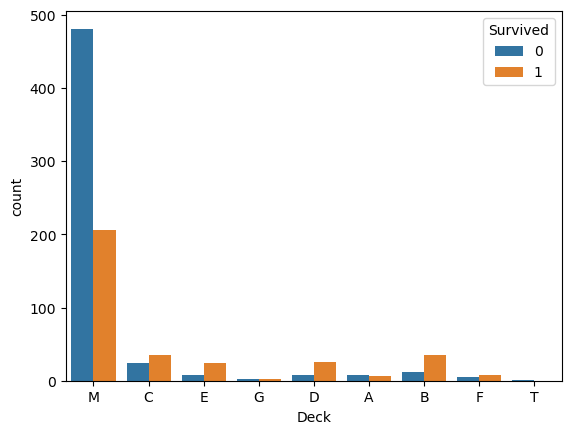

In [39]:
# Deck 컬럼 시각화
# Deck 컬럼의 결측치를 M으로 채웠는데, 사용 여부에 대해 시각화를 통해 확인
sns.countplot(data = train, 
             x = "Deck", 
             hue = "Survived")
plt.show()

# Deck 컬럼은 삭제하지 않고, 활용하는 쪽으로 진행! -> 사망자가 월등히 높아서, 예측을 수행하는 데 있어서 지표로 삼아볼만 함!!

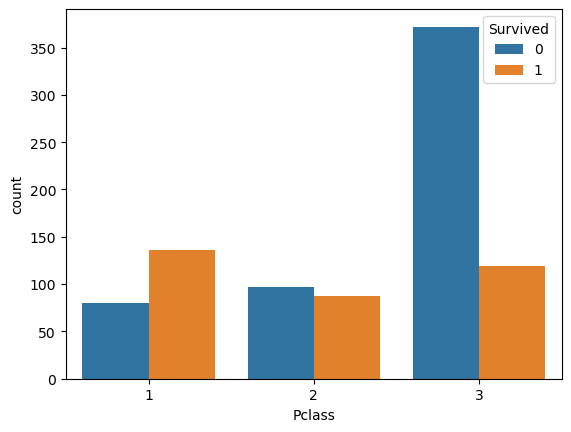

In [40]:
# Pclass 시각화
sns.countplot(data =train, 
             x = "Pclass", 
             hue = "Survived")
plt.show()

# 3등급인 경우 사망자 비율이 매우 높음
# 1등급인 경우 생존자 비율이 조금 더 높음

In [41]:
train['Pclass'] = train['Pclass'].astype(str) # 문자형으로 업데이트!

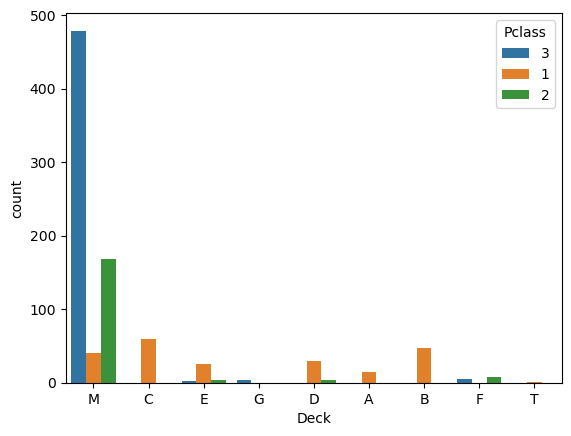

In [42]:
# 3등급이였던 사람들을 확인해보니 사망자 비율이 높았음
# Deck에서도 M(결측치)도 사망자 비율이 높았음
# 3등급이였던 사람들이 결측치였을 확률이 높지 않을까??

# Deck, Pclass 시각화
sns.countplot(data = train, 
             x = "Deck",
             hue = "Pclass")
plt.show()
# 결측치 였던 사람들 대부분이 3등급이였음 -> 3등급이면서 M이면 죽을 확률이 높아보임 -> 생존 여부에 영향을 크게 미침!

In [43]:
train['Pclass'] = train['Pclass'].astype(np.int64) # 원핫인코딩 진행이 안 되게끔 숫자형으로 다시 변경

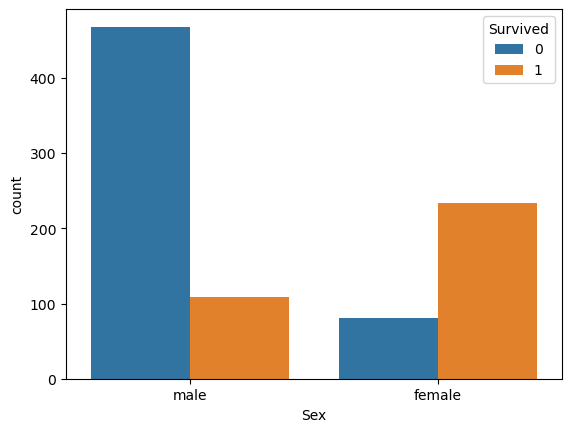

In [44]:
# 성별 데이터 시각화
sns.countplot(data = train, 
             x = "Sex", 
             hue = "Survived")
plt.show()

# 남성인 경우 죽을 확률이 높았다! -> Deck가 'M'이면서, Pclass이 3이면서, 남성인 경우 죽을 확률이 매우 높아짐!
# 여성인 경우 생존할 확률이 높았다!

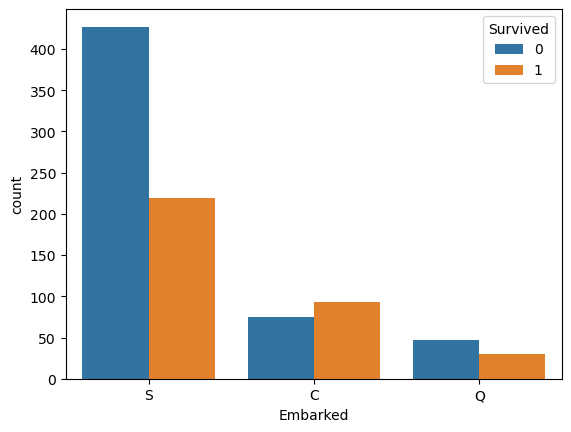

In [45]:
# 승선항에 따른 생존 여부 비율 확인
sns.countplot(data = train, 
             x = "Embarked", 
             hue = "Survived")
plt.show()

# S항구에서 탑승한 인원이 사망 확률이 높다 (추측 : 3등급이 많이 타지않았을까?)
# C항구는 생존자가 조금 더 많다
# Q항구는 사망자가 조금 더 많다

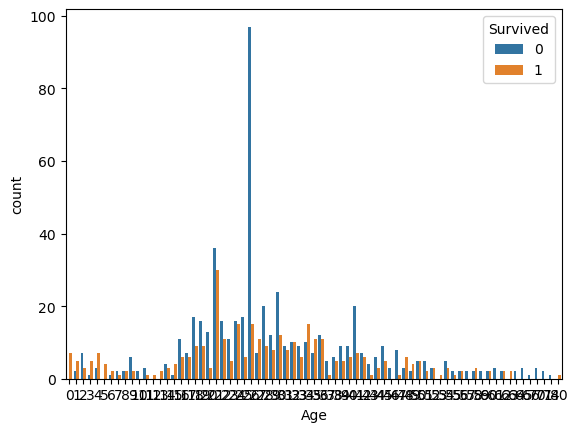

In [46]:
# 나이 시각화
sns.countplot(
    data = train, 
    x = "Age", 
    hue = "Survived"
)
plt.show()

# 나이데이터를 countplot으로 시각화 했더니, 해석하기가 힘듬

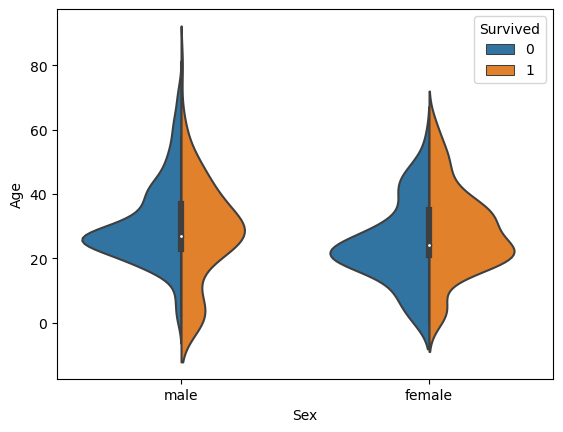

In [47]:
# 바이올린 플롯 : 바이올린 형태로 데이터의 분포와 밀도를 보기 좋게 곡선으로 표현한 그래프
# 데이터가 많이 존재하는 부분은 두껍게
# 데이터가 적게 존재하는 부분은 얇게

sns.violinplot(
    data = train, 
    x = "Sex", 
    y = "Age", 
    hue = "Survived", 
    split = True
)
plt.show()

# 20대 ~ 40대 사이의 탑승자가 많음을 확인
# 어린아이들 중에서 남자아이가 유독 생존자가 많음을 확인 -> 남아선호사상의 관념이 자리잡혀 있었음 -> 혈통을 유지하기 위해...!

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    object 
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 83.5+ KB


In [49]:
train.head()
# SibSp : 형제, 자매, 배우자의 수
# Parch : 부모, 자녀의 수

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,M
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,M
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,C
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,M


### 특성공학(Feature engineering)
- 특성들을 파악하여 합치거나, 나누었을 때 유의미한 결과를 내도록 변형
- Parch, SibSp 두 특성을 합치면 가족 구성원이라는 새로운 특성을 만들어볼 수 있음 -> Family

In [50]:
train["Family"] = train['Parch'] + train["SibSp"] + 1 # 나 자신 더해주기!
test["Family"] = test['Parch'] + test["SibSp"] + 1 # test set도 동일한 입력 특성의 개수를 위해 맞춰주기!

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    object 
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
 11  Family    891 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 90.5+ KB


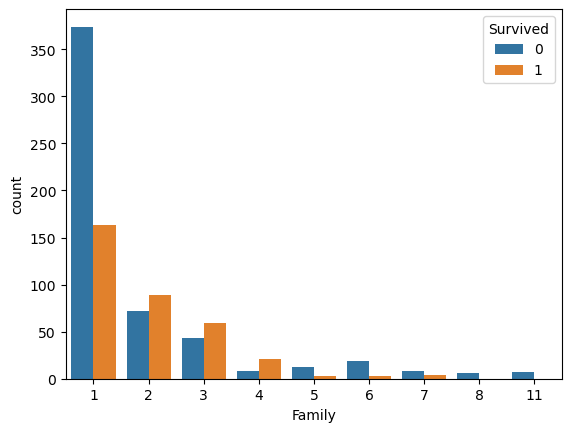

In [52]:
# 가족 구성원 수에 따른 생존 비율
sns.countplot(
    data = train, 
    x = "Family",
    hue = "Survived"
)
plt.show()
# 1명일 때 사망 비율이 높다!
# 2 ~ 4명일 때 생존 비율이 조금 더 높다!
# 5명 이상일 때 사망비율이 높다!
# 사소한 관찰의 오류 : 데이터가 한쪽으로 편향되어 있다보니, 비교적 특징이 잘 안 보임...
# -> 범주화(Bining) : 숫자형을 문자형으로 변환!

In [53]:
# 카테고리화  진행
# Family -> 1:'Alone', 2~4:'Small', 5~:'Large'
bins = [0, 1, 4, 11]
labels = ['Alone', 'Small', 'Large']

train["Family"] = pd.cut(train["Family"], bins = bins, labels = labels)
test["Family"] = pd.cut(test["Family"], bins = bins, labels = labels)

In [54]:
train["Family"]

PassengerId
1      Small
2      Small
3      Alone
4      Small
5      Alone
       ...  
887    Alone
888    Alone
889    Small
890    Alone
891    Alone
Name: Family, Length: 891, dtype: category
Categories (3, object): ['Alone' < 'Small' < 'Large']

C:\Users\smhrd1\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\smhrd1\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


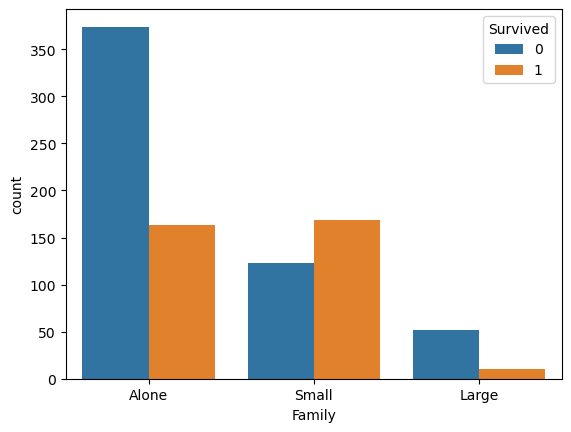

In [55]:
sns.countplot(
    data = train, 
    x = "Family",
    hue = "Survived"
)
plt.show()
# 범주화를 진행하여 시각화를 수행하니, 좀 더 명확한 특징을 파악할 수 있었음!
# 1명일 때와 5명 이상일 때 사망 비율이 좀 더 높았음! -> 사소한 분석 오류를 피할 수 있다!

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    object  
 1   Pclass    891 non-null    int64   
 2   Name      891 non-null    object  
 3   Sex       891 non-null    object  
 4   Age       891 non-null    int64   
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Embarked  891 non-null    object  
 10  Deck      891 non-null    object  
 11  Family    891 non-null    category
dtypes: category(1), float64(1), int64(4), object(6)
memory usage: 84.5+ KB


In [57]:
train['Name']
# 성, 호칭. 이름
# 미스터, 미스, 닥터... -> 호칭들만 추출해서, 생존 여부에 영향을 주는지 파악해보자!

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [58]:
# 호칭추출
# train["Name"][1].split(",") : ","를 기준으로 문자열 분리
# train["Name"][1].split(",")[1] : 호칭과 이름이 담긴 문자열 요소를 인덱싱
# train["Name"][1].split(",")[1].split(".") : "."를 기준으로 문자열 분리
# train["Name"][1].split(",")[1].split(".")[0] : 호칭이 담긴 문자열 요소를 인덱싱
# strip() : 공백 제거
train["Name"][5].split(",")[1].split(".")[0].strip()

'Mr'

In [59]:
# Name의 모든 데이터에 호칭을 추출하기 위해 함수 정의
def split_name(data) :
    return data.split(",")[1].split(".")[0].strip()

In [60]:
# apply(1D) 적용
train["Title"] = train["Name"].apply(split_name)
test["Title"] = test["Name"].apply(split_name)

In [61]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

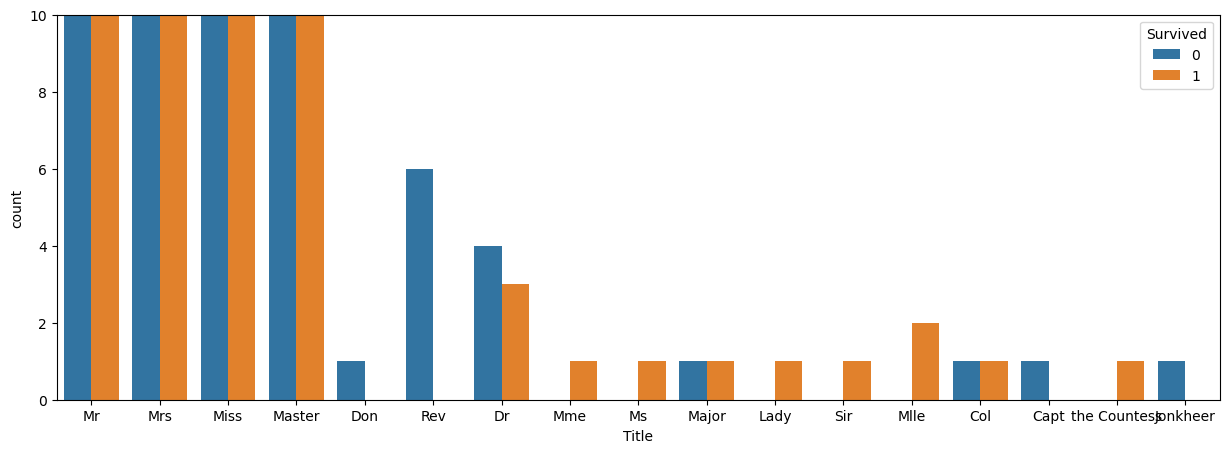

In [62]:
plt.figure(figsize = (15, 5))
sns.countplot(
    data = train, 
    x = "Title", 
    hue = "Survived"
)
plt.ylim(0, 10)
plt.show()

In [63]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [64]:
# title = list(train['Title'].unique()) # 매핑되는 순서를 맞춰줘야 함!!

In [65]:
# 매핑되는 순서를 고려하여 'Don'과 'Rev' 호칭을 순서를 바꿔줌
title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Don', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']

In [66]:
# 우리가 생각하기에 중요한 호칭들은 그대로 사용하고 나머지는 other로 바꿔주기 위해 map 인수에 들어갈 딕셔너리의 value 값 생성
convert_title = ['Mr', 'Mrs', 'Miss', 'Master', 'Rev'] + ['Other'] * 12

In [67]:
# dict 만들기
title_dict = dict(zip(title, convert_title))

In [68]:
# map : 딕셔너리를 인자로 받음, key을 value로 바꾸는 기능(라벨 인코딩 때도 활용)

train["Title"] = train["Title"].map(title_dict)

In [69]:
train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev'], dtype=object)

In [70]:
test["Title"].map(title_dict).unique() 
# nan -> map 함수 사용할 때 key값들 중 해당되지 않는 요소가 존재한다면, nan으로 반환

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Rev', nan], dtype=object)

In [71]:
# 집합 : set(), 중복이 없음, 순서가 없음

# test Title에서 train Title 빼기 -> Dona
# Dona가 test set에만 있는 Title!
set(test["Title"].unique()) - set(title)

{'Dona'}

In [72]:
test[test["Title"] == "Dona"]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Family,Title
PassengerId,,,,,,,,,,,,
1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9,C,C,Alone,Dona


In [73]:
# 딕셔너리 수정 -> Dona 추가
title_dict["Dona"] = "Other"

In [74]:
title_dict

{'Mr': 'Mr',
 'Mrs': 'Mrs',
 'Miss': 'Miss',
 'Master': 'Master',
 'Rev': 'Rev',
 'Don': 'Other',
 'Dr': 'Other',
 'Mme': 'Other',
 'Ms': 'Other',
 'Major': 'Other',
 'Lady': 'Other',
 'Sir': 'Other',
 'Mlle': 'Other',
 'Col': 'Other',
 'Capt': 'Other',
 'the Countess': 'Other',
 'Jonkheer': 'Other',
 'Dona': 'Other'}

In [75]:
test["Title"] = test["Title"].map(title_dict)

In [76]:
test["Title"]

PassengerId
892         Mr
893        Mrs
894         Mr
895         Mr
896        Mrs
         ...  
1305        Mr
1306     Other
1307        Mr
1308        Mr
1309    Master
Name: Title, Length: 418, dtype: object

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    object  
 1   Pclass    891 non-null    int64   
 2   Name      891 non-null    object  
 3   Sex       891 non-null    object  
 4   Age       891 non-null    int64   
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Embarked  891 non-null    object  
 10  Deck      891 non-null    object  
 11  Family    891 non-null    category
 12  Title     891 non-null    object  
dtypes: category(1), float64(1), int64(4), object(7)
memory usage: 123.8+ KB


In [78]:
train["Ticket"].unique()
# 특정 패턴이나 규칙, 생존여부와 별 관계는 크게 없어보임
# 삭제

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [79]:
# Name, SibSp, Parch, Ticket 삭제
train.drop(["Name", "SibSp", "Parch", "Ticket"], axis = 1, inplace= True)
test.drop(["Name", "SibSp", "Parch", "Ticket"], axis = 1, inplace = True)

In [80]:
train.shape, test.shape
# 모델링 -> 입력특성을 동일 시 해줘야 함(차원의 수를 동일시 해야 함)

((891, 9), (418, 8))

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    object  
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    object  
 3   Age       891 non-null    int64   
 4   Fare      891 non-null    float64 
 5   Embarked  891 non-null    object  
 6   Deck      891 non-null    object  
 7   Family    891 non-null    category
 8   Title     891 non-null    object  
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 95.9+ KB


In [82]:
# 데이터 분리 -> train set의 X, y

X_train = train.drop("Survived", axis = 1)
y_train = train["Survived"]
X_test = test.copy() # 얕은 복사

In [83]:
# 원핫인코딩 진행(train, test 진행)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [84]:
X_train.shape, X_test.shape # 특성 개수가 다름!!!

((891, 26), (418, 25))

In [85]:
# 집합자료형을 활용해서 어떤 특성이 차이가 나는지 확인!
set(X_train.columns) - set(X_test.columns)

{'Deck_T'}

In [86]:
# Deck에서 T라는 값은 train set에만 있음
# Pclass의 경우 차트 error 때문에 train set만 str형으로 바꿔놓았음 -> 원핫인코딩이 수행되었음
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    int64  
 2   Fare          418 non-null    float64
 3   Sex_female    418 non-null    bool   
 4   Sex_male      418 non-null    bool   
 5   Embarked_C    418 non-null    bool   
 6   Embarked_Q    418 non-null    bool   
 7   Embarked_S    418 non-null    bool   
 8   Deck_A        418 non-null    bool   
 9   Deck_B        418 non-null    bool   
 10  Deck_C        418 non-null    bool   
 11  Deck_D        418 non-null    bool   
 12  Deck_E        418 non-null    bool   
 13  Deck_F        418 non-null    bool   
 14  Deck_G        418 non-null    bool   
 15  Deck_M        418 non-null    bool   
 16  Family_Alone  418 non-null    bool   
 17  Family_Small  418 non-null    bool   
 18  Family_Large  418 non-null    bo

In [87]:
X_train[X_train["Deck_T"] == 1]

,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,...,Deck_T,Family_Alone,Family_Small,Family_Large,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Rev
PassengerId,,,,,,,,,,,,,,,,,,,,,
340,1,45,35.5,False,True,False,False,True,False,False,...,True,True,False,False,False,False,True,False,False,False


In [88]:
# sklearn에서 제공되는 모델들은 입력을 동일 시 해줘야 함
# 그래서 Deck_T라는 컬럼을 0으로 초기화해서 추가함
X_test["Deck_T"] = 0

In [89]:
X_train.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'Family_Alone',
       'Family_Small', 'Family_Large', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'Title_Rev'],
      dtype='object')

In [90]:
X_test.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_Alone', 'Family_Small',
       'Family_Large', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Title_Rev', 'Deck_T'],
      dtype='object')

In [91]:
# 컬럼의 순서 재배치를 위해 train set의 Deck_T 순서를 변경

# 임의의 변수에 Deck_T를 할당
temp = X_train["Deck_T"]

In [92]:
# 원래 train set의 Deck_T를 삭제
X_train.drop("Deck_T", axis = 1, inplace=True)

In [93]:
# X_train, Deck_T를 병합
X_train = pd.concat([X_train, temp], axis = 1)

In [94]:
X_train.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_Alone', 'Family_Small',
       'Family_Large', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Title_Rev', 'Deck_T'],
      dtype='object')

In [95]:
X_test.columns

Index(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Family_Alone', 'Family_Small',
       'Family_Large', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Title_Rev', 'Deck_T'],
      dtype='object')

In [96]:
set(X_train.columns) - set(X_test.columns)

set()

In [97]:
X_train.shape, X_test.shape

((891, 26), (418, 26))

### 모델 선택 및 학습
- 여태 배웠던 모델 : KNN 알고리즘, Decision Tree

In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

- knn 모델

In [99]:
# 객체 생성(모델 초기화)
knn_model = KNeighborsClassifier()

# 학습
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [100]:
# 예측
y_pred = knn_model.predict(X_test)

# y_test(정답)은 kaggle이 가지고 있음
# 정답을 제출할 omr카드

In [101]:
result = pd.read_csv("./data/gender_submission.csv")
result["Survived"] = y_pred
result.to_csv("data/JBG_KNN_sub01.csv", index = False)

- DT 모델

In [102]:
# 객체 생성(모델 초기화)
dt_model = DecisionTreeClassifier()

# 학습
dt_model.fit(X_train, y_train)

# 예측
y_pred = dt_model.predict(X_test)

# 답지 제작
result = pd.read_csv("./data/gender_submission.csv")
result["Survived"] = y_pred
result.to_csv("data/JBG_DT_sub01.csv", index = False)

##### 결과
- KNN : 65.31%
- DT : 72.24%

- 결과 해석 : 성능 개선이 필요함
    - 데이터양을 늘리기
    - 전처리 방식 수정
    - 하이퍼 파라미터 조절(5% 내외로 성능이 올라감)
    - 더 좋은 모델 선택

In [103]:
knn_model.score(X_train, y_train) # knn 모델은 과소적합의 현상을 보임
# 이유 : knn 모델은 알고리즘이 간단한 대신에, 성능이 좋지 못 함

0.8159371492704826

In [104]:
dt_model.score(X_train, y_train) # dt 모델은 과대적합의 현상을 보임
# 이유 : train set은 어느정도 잘 맞춤, test set은 너무 낮음 -> 하이퍼 파라미터 설정을 하지 않음!

0.9854096520763187

### 데이터 스케일링
- Feature들의 데이터 분포, 범위를 동일하게 조정하는 작업
- 거리(ex.knn, kmean 등), 수치(ex.선형분류, 선형회귀) 기반의 학습을 진행하는 모델에게 적용
    - 거리나 수치기반이 아닌 경우 -> Decision Tree 계열
---
- 장점 : 범위를 일정하게 맞추어 모델이 데이터를 더 쉽게 처리하고, 모델 성능 향상으로 이어짐
- 단점 : 데이터의 원래 의미(값)가 변경 되기 때문에, 원래 범위를 유지하는게 더 좋다고 판다되면 scaling을 하지 않는게 왜곡을 방지할 수 있음

In [105]:
from sklearn.preprocessing import StandardScaler # 스케일링 도구

In [106]:
# 객체 초기화
scaler = StandardScaler()

In [107]:
# fit : 해당 데이터를 기준으로 스케일 기준 설정
# fit_transform : 해당 데이터를 기준으로 스케일 기준 설정 후 바로 변환
# transform : 기존에 정해진 기준으로 변환

scaler.fit(X_train) # 스케일 기준 설정

StandardScaler()

In [108]:
# 스케일 기준이 만들어진 스케일러의 범위 변환
t_X_train = scaler.transform(X_train) # 변환

In [109]:
t_X_test = scaler.transform(X_test) # 변환만 수행

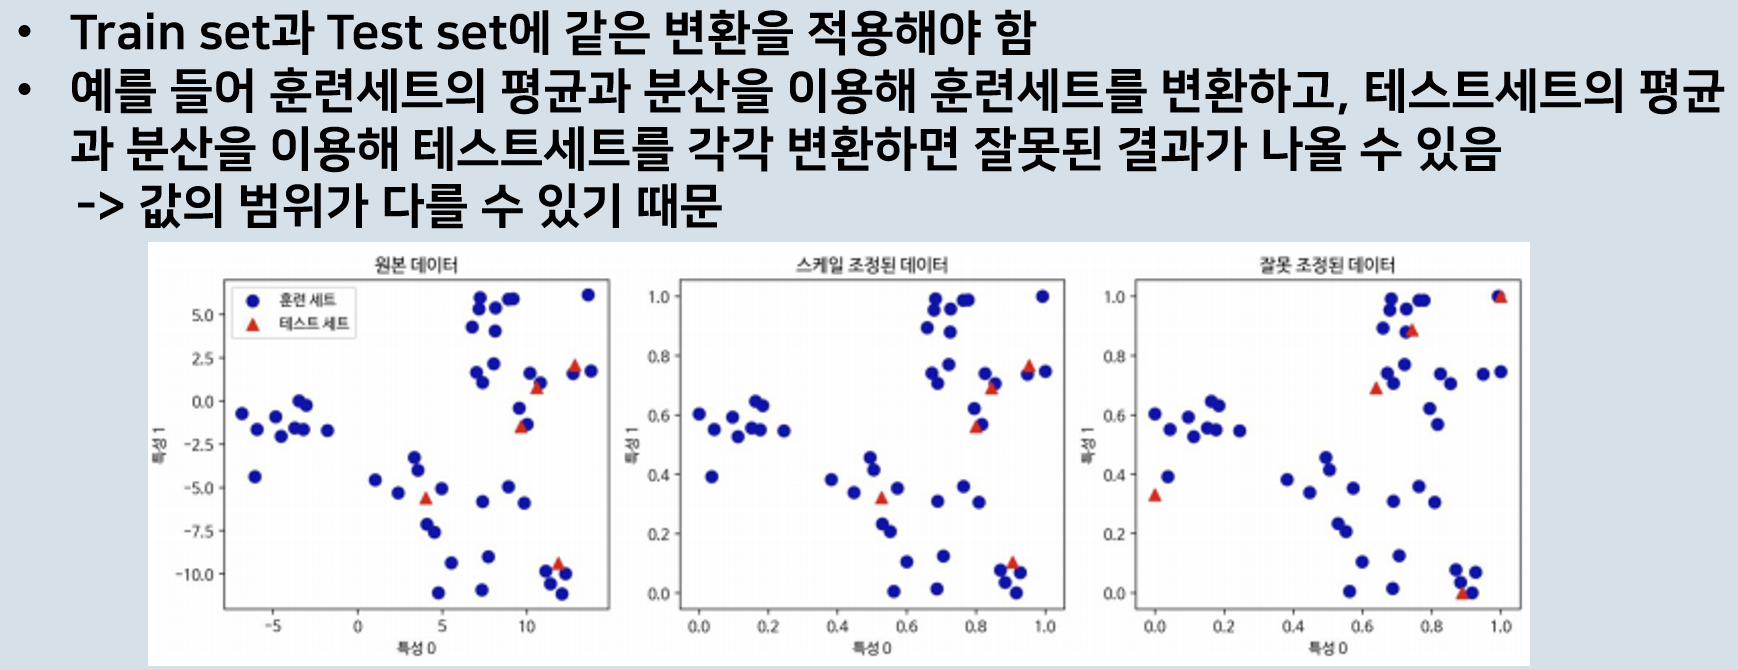

In [110]:
# 스케일링 이후 모델 학습
knn_model2 = KNeighborsClassifier()

In [111]:
# 학습
knn_model2.fit(t_X_train, y_train)

KNeighborsClassifier()

In [112]:
# 검증으로 성능 확인

In [113]:
from sklearn.model_selection import cross_val_score

In [114]:
cross_val_score(knn_model, X_train, y_train, cv = 5).mean()
# 스케일링 적용 X : 약 71%의 검증 성능을 보임

0.7104764296026616

In [115]:
cross_val_score(knn_model2, t_X_train, y_train, cv = 5).mean()
# 스케일링 적용 O : 약 80%의 검증 성능을 보임
# 이유 : 특정 컬럼이 다른 컬럼에 비해 뭉쳐져 있던 상황을 스케일링으로 풀어서, 
# knn 알고리즘이 더 잘 수렴하게끔 성능이 향상됨을 확인

0.809189630280585

### 앙상블(Ensemble)
- 여러 모델을 결합하는 방식으로 활용하여, 성능을 올리는 기법

#### 1. 보팅(Voting)
- 여러 개의 <b>다른 종류의 모델</b>이 예측한 결과를 <b>투표 혹은 평균</b>을 통해 최종 결정하는 방식
    - 하드 보팅 : 다수결(예측값을 모아서 투표하는 방식)
    - 소프트 보팅 : 확률값을 통한 결정

In [116]:
# 보팅 도구 불러오기
from sklearn.ensemble import VotingClassifier

# 확률값들을 제공하는 모델들도 같이 불러오기
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀모델 (분류만 가능) 선형 분류 모델
from sklearn.svm import SVC # 서포트 벡터 머신

In [117]:
# 모델 초기화

log_clf = LogisticRegression(max_iter = 10000)
# 로지스틱 회귀 모델 (분류만 가능)
# 분류 알고리즘 중 하로, 주어진 데이터가 특정 분류에 속할 확률을 추정
# 결과는 0~1 사이의 값, 0.5를 기준으로 특정 클래스에 속할 확률을 나타냄
# max_iter 는 알고리즘이 수렴할 때까지 반복하는 최대 횟수를 지정(학습 빈도수 설정)

svm_clf = SVC(probability = True)
# 서포트 벡터 머신
# 결정경계 선(또는 면)을 만들어서 새로운 데이터 포인트가 어느 클래스에 속할지 예측하는 모델
# 기본적으로 확률값을 제공하지는 않음...
# probability = True -> SVM모델이 원래 확률값을 제공을 안 하는데, 추가 연산을 통해서 확률값을 제공하게끔 설정하는 옵션

In [118]:
# 하드 보팅 분류기
hard_voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('svc', svm_clf)], # 모델 지정
    voting = 'hard' # 보팅 방식 지정
)

# 학습
hard_voting_clf.fit(t_X_train, y_train)

# 검증
cross_val_score(hard_voting_clf, t_X_train, y_train, cv = 5).mean()

0.8294017952419811

In [119]:
# 소프트 보팅 분류기
soft_voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('svc', svm_clf)], # 모델 지정
    voting = 'soft' # 보팅 방식 지정
)

# 학습
soft_voting_clf.fit(t_X_train, y_train)

# 검증
cross_val_score(soft_voting_clf, t_X_train, y_train, cv = 5).mean()

0.8294017952419811

#### 2. 배깅(Bagging)
- 여러 개의 <b>같은 종류의 모델</b>이 예측한 결과를 <b>투표 혹은 평균</b>을 통해 최종 결정하는 방식
- 대표 모델 : RandomForest 모델 등

In [120]:
from sklearn.ensemble import RandomForestClassifier

In [121]:
# 모델 초기화
rf_clf = RandomForestClassifier(
    n_estimators = 100, # 100개 트리
    random_state = 2024
)
# random_state : 난수 고정, 고정시키지 않는다면 실행할 때마다 데이터셋이 달라지기 때문에 성능 평가 때 영향을 미치게 됨!

In [122]:
# 학습
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=2024)

In [123]:
# 검증
cross_val_score(rf_clf, X_train, y_train, cv = 5).mean()

0.8136777352331931

##### 그리드서치(GridSearchCV) 적용해서 최적의 하이퍼파라미터 찾기
- 어떠한 하이퍼 파라미터가 적합한 하이퍼 파라미터인지 찾게 도와주는 기능

In [124]:
from sklearn.model_selection import GridSearchCV

In [125]:
# 1. 하이퍼파라미터 경우의 수 설정
params = {
    "n_estimators":[50, 100, 200], # 트리의 개수
    "max_depth":[3, 5, 7], # 트리의 최대 깊이를 지정
    "max_leaf_nodes":[2, 4, 6], # 리프 노드의 최대 샘플 개수 제한
    "min_samples_split":[3, 5, 7] # 노드를 분할하기 위한 최소 샘플 개수를 지정
}

# 2. 대상 모델 초기화(모델 생성)
rf_clf = RandomForestClassifier(random_state = 2024)

# 3. 그리드 서치 옵션 설정
grid = GridSearchCV(
    rf_clf, # 모델 설정
    params, # 하이퍼파라미터 경우의 수 설정
    cv = 5, # 5겹 fold 교차 검증 수행
    scoring = "accuracy", # 모델의 평가지표 설정(ex.recall, auc_roc...)
    n_jobs = -1 # 사용 가능한 모든 CPU 코어를 사용하여 병렬 처리를 수행
)

# 4. 실행(찾아라!)
grid.fit(X_train, y_train) # 그리드 서치를 수행하여 최적의 하이퍼파라미터 조합을 찾음!

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2024),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_leaf_nodes': [2, 4, 6],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [126]:
print("최적의 하이퍼 파라미터 조합 :", grid.best_params_)
print("최적의 하이퍼 파라미터 조합의 정확도 :", grid.best_score_)

최적의 하이퍼 파라미터 조합 : {'max_depth': 5, 'max_leaf_nodes': 6, 'min_samples_split': 3, 'n_estimators': 50}
최적의 하이퍼 파라미터 조합의 정확도 : 0.8170359676103194


In [127]:
# 다시 최적의 하이퍼 파라미터로 모델링!
best_rf_clf = RandomForestClassifier(
    max_depth = 5,
    max_leaf_nodes = 6, 
    min_samples_split = 3,
    n_estimators = 50,
    random_state = 2024
)

# 학습
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=6, min_samples_split=3,
                       n_estimators=50, random_state=2024)

In [128]:
# 검증
cross_val_score(best_rf_clf, X_train, y_train, cv = 5).mean()

0.8170359676103194

#### 특성 중요도 확인
- tree 계열 모델들의 장점 중 하나가 특성 중요도를 확인 가능 -> Feature Selection 때 활용!
- RandomForest도 tree 계열이기 때문에 특성중요도 확인 가능!

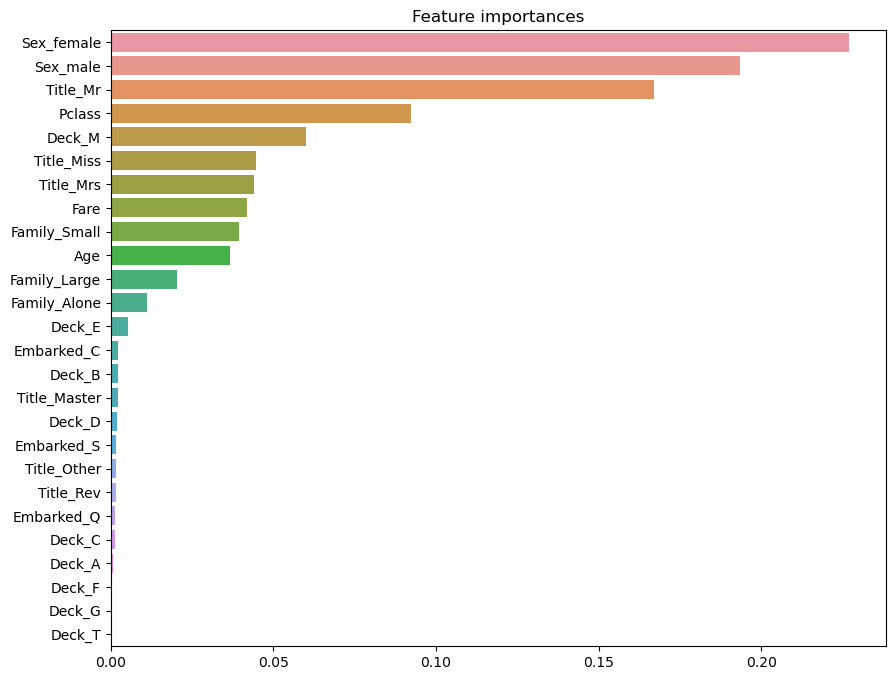

In [129]:
ftex = best_rf_clf.feature_importances_ # 특성 중요도
ftex_series = pd.Series(ftex, index = X_train.columns) # 각각의 컬럼 매핑을 시리즈 형변환
ftex_series = ftex_series.sort_values(ascending = False) # 내림차순으로 정렬

plt.figure(figsize = (10, 8))
plt.title("Feature importances")
sns.barplot(x = ftex_series, y = ftex_series.index)
plt.show()

#### 3. 부스팅(Boosting)
- 여러 개의 <b>같은 종류의 모델</b>이 순차적으로 학습하여, 오분류(오차)에 가중치를 부여해 개선해나가는 방식
- Boosting 종류
    - AdaBoost (Adaptive Boosting)
        - 오분류 된 데이터 포인트에 더 큰 가중치를 할당하고, 이를 통해 새로운 분류기가 이전의 오류를 적응하여 개선
        - 각 반복에서 올바르게 분류된 샘플의 가중치는 감소하고, 잘 못 분류 된 샘플의 가중치는 증가하여 오분류에 대한 데이터를 보완
        - 이해하기 쉬움
    - Gradient Boosting(GBM)
        - 오차값을 추출하는 도구(손실함수)를 활용해서 기울기를 사용하여 연속적으로 모델을 개선
    - XGBoost
        - GBM 확장버전 -> 성능이나 속도를 최적화
        - Kaggle 대회 등에서 널리 사용됨, 대규모 데이터셋이나 복잡한 문제에 매우 효과적

In [130]:
# AdaBoost, GBM 모델 불러오기
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [131]:
# AdaBoost 모델 초기화
ada_clf = AdaBoostClassifier(
    n_estimators = 100, # 트리 개수 지정
    random_state = 2024, 
    learning_rate = 0.1 # 학습률(보폭)
)

In [132]:
# 검증
cross_val_score(ada_clf, X_train, y_train, cv = 5).mean()

0.827154604230745

In [133]:
# GBM 모델 초기화
gb_clf = GradientBoostingClassifier(
    n_estimators = 100, # 트리 개수 지정
    random_state = 2024, 
    learning_rate = 0.1, # 학습률(보폭)
    max_depth = 5 # 트리 깊이 제한
)

In [134]:
# 검증
cross_val_score(gb_clf, X_train, y_train, cv = 5).mean()

0.8294080723118448

In [135]:
# xgboost는 별도로 설치 필요 (sklearn 제공 X)
!pip install xgboost

Active code page: 65001


In [136]:
from xgboost import XGBClassifier # XGBoost 모델 불러오기

In [137]:
xgb_clf = XGBClassifier(
    n_estimators = 200, 
    learning_rate = 0.1,
    max_depth = 5, 
    min_child_weight = 3 # 트리에서 추가 분할을 결정하기 위한 최소 가중치 합(과적합 방지용)
)

In [138]:
y_train = y_train.astype(np.int64) # xgb는 정답데이터도 숫자로 받길 원함!! 그래서 형변환 함

In [139]:
# 검증
cross_val_score(xgb_clf, X_train, y_train, cv = 5).mean()

0.8496139602033772